/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode: 1 time: 24
episode: 2 time: 24
episode: 3 time: 12
episode: 4 time: 12
episode: 5 time: 13
episode: 6 time: 24
episode: 7 time: 13
episode: 8 time: 8
episode: 9 time: 12
episode: 10 time: 9
episode: 11 time: 9
episode: 12 time: 10
episode: 13 time: 9
episode: 14 time: 10
episode: 15 time: 9
episode: 16 time: 10
episode: 17 time: 9
episode: 18 time: 10
episode: 19 time: 9
episode: 20 time: 10
episode: 1 time: 21
episode: 2 time: 21
episode: 3 time: 17
episode: 4 time: 18
episode: 5 time: 13
episode: 6 time: 13
episode: 7 time: 13
episode: 8 time: 11
episode: 9 time: 16
episode: 10 time: 17
episode: 11 time: 13
episode: 12 time: 15
episode: 13 time: 11
episode: 14 time: 13
episode: 15 time: 12
episode: 16 time: 14
episode: 17 time: 12
episode: 18 time: 15
episode: 19 time: 11
episode: 20 time: 12
episode: 1 time: 13
episode: 2 time: 21
episode: 3 time: 30
episode: 4 time: 32
episode: 5 time: 14
episode: 6 time: 17
episode: 7 time: 14
episode: 8 time: 11
episode: 9 time: 11
episo

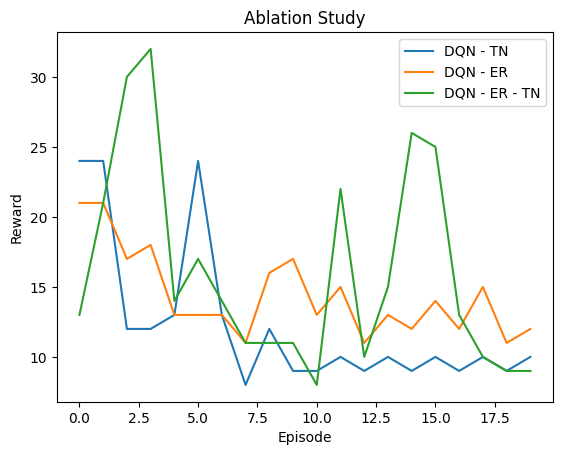

In [1]:
import numpy as np
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import AdamW
import gym
import itertools
from matplotlib import pyplot as plt


def argmax(x):
    ''' Own variant of np.argmax with random tie breaking, function of assignment 1  '''
    try:
        return np.random.choice(np.where(x == np.max(x))[0])
    except:
        return np.argmax(x)


def softmax(x, temp):
    ''' Computes the softmax of vector x with temperature parameter 'temp', function of assignment 1 '''
    x = x / temp  # scale by temperature
    z = x - max(x)  # substract max to prevent overflow of softmax
    return np.exp(z) / np.sum(np.exp(z))  # compute softmax


class DQAgent:
    def __init__(self, state_size, action_size, replay_memory_capacity=1000, epsilon=0.5, target=True, replay=True, learning_rate=0.001):
        self.state_size = state_size  # Set output size for Q-function
        self.action_size = action_size  # Set input size for Q-function
        self.memory = deque(maxlen=replay_memory_capacity)  # Initialize replay memory to capacity N
        self.gamma = 0.95  # Future rewards are discounted by gamma per time-step
        self.learning_rate = learning_rate  # Learning rate for gradient descent
        self.Q_network = self._build_model()  # Initialize action-value function Q with random weights
        self.Q_network_target = self._build_model()
        self.epsilon = epsilon  # Probability for random action
        self.epsilon_min = 0.01
        self.episodes_max = 10
        self.target = target  # If True predictions are made using an alternate network that undergoes periodic updates
        self.use_replay = replay # If True experience replay will be used

    def _build_model(self):  # Takes state as input, outputs Q values for legal actions
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=AdamW(learning_rate=self.learning_rate), metrics=['accuracy'])
        return model

    def store_transition(self, s, a, r, s_next, done):  # Stores transition in replay memory
        self.memory.append((s, a, r, s_next, done))

    def Q_value_predict(self, s):
        if self.target:
            return self.Q_network_target.predict(s, verbose=0)
        else:
            return self.Q_network.predict(s, verbose=0)

    def replay(self, batch_size):
        if self.use_replay:
            minibatch = random.sample(self.memory, batch_size)  # if experience replay is used experiences are randomly sampled from memory
        else:
            index = len(self.memory) - batch_size
            minibatch = list(itertools.islice(self.memory, index, None))  # if experience replay is not used the model is trained on the last experiences

        for s, a, r, s_next, done in minibatch:
            if done:
                y = r
            else:
                Q_next = np.amax(self.Q_value_predict(s_next)[0])
                y = r + self.gamma * Q_next
            Q = self.Q_value_predict(s)
            Q[0][a] = y
            self.Q_network.fit(s, Q, verbose=0)  # Keras builds the loss function akin to equation 3 as outlined in the DQN paper.

    def select_action(self, s, current_episode, method="anneal_epsilon"):
        random_action = env.action_space.sample() # Random action
        Q_values = self.Q_network.predict(s, verbose=0)  # Get Q-values from Q-function
        greedy_action = np.argmax(Q_values[0])  # action associated with the maximum Q-value
        if method == "egreedy":
            if self.epsilon >= np.random.rand():
                return random_action
            else:
                return greedy_action
        elif method == "anneal_epsilon":
            self.linear_annealing_epsilon(current_episode)
            if self.epsilon >= np.random.rand():
                return random_action
            else:
                return greedy_action
        elif method == "boltzmann":
            return argmax(softmax(Q_values, self.epsilon))

    def update_target_network(self):
        self.Q_network_target.set_weights(self.Q_network.get_weights())

    def linear_annealing_epsilon(self, current_episode):
        """Linear function decay of epsilon parameter """
        gradient_epsilon = (self.epsilon_min - 1.0) / self.episodes_max
        self.epsilon = gradient_epsilon * current_episode + 1.0


def run_scenario(agent, episodes):
    rewards = []

    for e in range(episodes):
        s = env.reset()
        s = np.array([s]).reshape([1, state_size])
        done = False
        time = 0
        while not done or time >= 500:
            a = agent.select_action(s, e, "anneal_epsilon")
            step_result = env.step(a)
            s_next, r, done, _ = step_result[:4]
            s_next = np.reshape(s_next, [1, state_size])
            agent.store_transition(s, a, r, s_next, done)

            if len(agent.memory) >= batch_size:
                agent.replay(batch_size)

            s = s_next
            time += 1
            if time % 10 == 0 and agent.target:
                agent.update_target_network()

        print('episode:', e + 1, 'time:', time)
        rewards.append(time)

    return rewards

if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    episodes_max = 20
    batch_size = 16

    # Scenario 1: DQN without Target Network
    agent_no_tn = DQAgent(state_size, action_size, replay=True, target=False, learning_rate=0.001)
    rewards_no_tn = run_scenario(agent_no_tn, episodes_max)

    # Scenario 2: DQN without Experience Replay
    agent_no_er = DQAgent(state_size, action_size, replay=False, target=True, learning_rate=0.001)
    rewards_no_er = run_scenario(agent_no_er, episodes_max)

    # Scenario 3: DQN without both Target Network and Experience Replay
    agent_no_tn_er = DQAgent(state_size, action_size, replay=False, target=False, learning_rate=0.001)
    rewards_no_tn_er = run_scenario(agent_no_tn_er, episodes_max)

    # Plotting rewards for all scenarios
    plt.plot(rewards_no_tn, label="DQN - TN")
    plt.plot(rewards_no_er, label="DQN - ER")
    plt.plot(rewards_no_tn_er, label="DQN - ER - TN")
    plt.title("Ablation Study")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()
    env.close()
